### Dino features from scrolls

# Импорты

In [1]:
import numpy as np
import os
import torch
import glob
from PIL import Image
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
from sklearn.manifold import TSNE
import umap
import pandas as pd
from tqdm import tqdm
from torch.nn.functional import interpolate
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = str(2**32)  # 4 гигапикселя
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 933120000
import cv2


In [2]:
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg')
if torch.cuda.is_available():
    model = model.cuda()
model.eval()

Using cache found in /home/jovyan/.cache/torch/hub/facebookresearch_dinov2_main
/home/jovyan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/jovyan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/jovyan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [5]:
import os
import gc
import json
import wandb
import argparse
from datetime import datetime

import cv2
import math
import random
import PIL.Image
import threading
import numpy as np
import pandas as pd
import tifffile as tiff
import scipy.stats as st
import matplotlib.pyplot as plt

from tqdm import tqdm
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
import segmentation_models_pytorch as smp

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from timesformer_pytorch import TimeSformer

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
# from warmup_scheduler import GradualWarmupScheduler

from dinov2.utils.config import setup
from dinov2.train.ssl_meta_arch import SSLMetaArch

join = os.path.join



class CFG:
    # ============== comp exp name =============
    comp_name = "vesuvius"
    comp_dir_path = "./"
    comp_folder_name = "./"
    exp_name = "vit_dinov2_s1_161224"
    root = "/raid/cian/user/sergei.pnev/VC/VC_224/"
    comp_dataset_path = f"/raid/cian/user/sergei.pnev/VC/"
    segments_json_path = "segments.json"

    # ============== model cfg =============
    in_chans = 16  #

    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 4
    pred_shape = (224, 224)
    train_batch_size = 128  # 32
    valid_batch_size = train_batch_size * 2

    num_workers = 16

    # ============== set dataset path =============
    save_dir = f"./{exp_name}/"
    dino_checkpoint_path = f"/home/jovyan/Bulygin/dinov2-vesuvius/models/model_0093749.rank_0.pth"

    # weights for ViT pretrained on segments from Scroll 1 and Scroll 5
    vit_checkpoint_path = f"/home/jovyan/Bulygin/dinov2-vesuvius/models/baseline_190924_model_0093749_s1s5.pth"

    # ============== augmentation =============
    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(mean=[0] * in_chans, std=[1] * in_chans),
        ToTensorV2(transpose_mask=True),
    ]
    rotate = A.Compose([A.Rotate(5, p=1)])


def read_image_mask(fragment_id, start_idx=17, end_idx=43, CFG=CFG, fold="train_scrolls"):
    images = []
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in idxs:
        if os.path.exists(
            CFG.comp_dataset_path + f"{fold}/{fragment_id}/layers/{i:02}.tif"
        ):
            image = cv2.imread(
                CFG.comp_dataset_path
                + f"{fold}/{fragment_id}/layers/{i:02}.tif",
                0,
            )
        elif os.path.exists(
                CFG.comp_dataset_path + f"{fold}/{fragment_id}/layers/{i:02}.png"
        ):
            image = cv2.imread(
                CFG.comp_dataset_path
                + f"{fold}/{fragment_id}/layers/{i:02}.png",
                0,
            )
        else:
            image = cv2.imread(
                CFG.comp_dataset_path
                + f"{fold}/{fragment_id}/layers/{i:02}.jpg",
                0,
            )
        print()
        pad0 = CFG.tile_size - image.shape[0] % CFG.tile_size
        pad1 = CFG.tile_size - image.shape[1] % CFG.tile_size
        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)
        image = np.clip(image, 0, 200)
        images.append(image)
    images = np.stack(images, axis=2)
    if any(
        id_ in fragment_id
        for id_ in [
            "20230701020044",
            "verso",
            "20230901184804",
            "20230901234823",
            "20230531193658",
            "20231007101615",
            "20231005123333",
            "20231011144857",
            "20230522215721",
            "20230919113918",
            "20230625171244",
            "20231022170900",
            "20231012173610",
            "20231016151000",
        ]
    ):
        images = images[:, :, ::-1]
    fragment_mask = cv2.imread(
        CFG.comp_dataset_path + f"{fold}/{fragment_id}/{fragment_id}_mask.png",
        0,
    )
    fragment_mask = np.pad(fragment_mask, [(0, pad0), (0, pad1)], constant_values=0)
    return images, fragment_mask, (pad0, pad1)


def get_img_splits(fragment_id, CFG=CFG):
    images = []
    xyxys = []

    image, fragment_mask, (pad0, pad1) = read_image_mask(fragment_id, CFG=CFG)
    x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
    y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

    for y1 in y1_list:
        for x1 in x1_list:
            y2 = y1 + CFG.tile_size
            x2 = x1 + CFG.tile_size
            if not np.any(fragment_mask[y1:y2, x1:x2]==0):
                images.append(image[y1:y2, x1:x2])
                xyxys.append([x1, y1, x2, y2])

    test_dataset = CustomDatasetTest(images,np.stack(xyxys), CFG,transform=A.Compose([
        A.Resize(CFG.size, CFG.size),
        A.Normalize(
            mean= [0] * CFG.in_chans,
            std= [1] * CFG.in_chans
        ),
        ToTensorV2(),
    ]))

    test_loader = DataLoader(test_dataset,
                              batch_size=CFG.valid_batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False,
                              )
    return test_loader, np.stack(xyxys), (image.shape[0],image.shape[1]), fragment_mask, (pad0, pad1)


class CustomDatasetTest(Dataset):
    def __init__(self, images,xyxys, cfg, transform=None):
        self.images = images
        self.xyxys=xyxys
        self.cfg = cfg
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        xy=self.xyxys[idx]
        if self.transform:
            data = self.transform(image=image)
            image = data['image']
        return image, xy


class Block(nn.Module):
    def __init__(self, in_features, hidden_dim):
        super(Block, self).__init__()
        self.block = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_features, hidden_dim, kernel_size=(3, 3),  padding=(1, 1)),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=(3, 3),  padding=(1, 1)),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),
        )

    def forward(self, x):
        return self.block(x)

# simple conv Decoder
class ConvHead(nn.Module):
    def __init__(self, embedding_size=768, hidden_dim=512, num_classes=1):
        super(ConvHead, self).__init__()
        print(hidden_dim / 2)
        self.block_1 = Block(embedding_size, hidden_dim)
        self.block_2 = Block(hidden_dim, 256)
        self.block_3 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 64, kernel_size=(3, 3),  padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, num_classes, kernel_size=(3, 3),  padding=(1, 1)),
        )
        self.up = nn.Upsample(scale_factor=2),

    def forward(self, x):
        x_1 = self.block_1(x)
        x_2 = self.block_2(x_1)
        x_3 = self.block_3(x_2)
        return x_3


class RegressionPLModel(pl.LightningModule):
    def __init__(self, cfg, pred_shape, size=256, with_norm=False):
        super(RegressionPLModel, self).__init__()

        self.save_hyperparameters()
        self.mask_pred = np.zeros(self.hparams.pred_shape)
        self.mask_count = np.zeros(self.hparams.pred_shape)

        self.loss_func1 = smp.losses.DiceLoss(mode="binary")
        self.loss_func2 = smp.losses.SoftBCEWithLogitsLoss(smooth_factor=0.25)
        self.loss_func = lambda x, y: 0.5 * self.loss_func1(
            x, y
        ) + 0.5 * self.loss_func2(x, y)

        self.backbone = None
        self.head = ConvHead()

        if self.hparams.with_norm:
            self.normalization = nn.BatchNorm3d(num_features=1)

    def forward_backbone(self, x, B, out_indices=[1, 2, 3]):
        with torch.no_grad():
            x = self.backbone.forward_features(x, out_indices=out_indices)["x_norm_patchtokens"]
            x = x.permute(0, 2, 1)
            x = x.reshape((B, 768, 16, 16))
        return x

    def forward(self, x, out_indices=[1, 2, 3]):
        B = x.shape[0]
        x = self.forward_backbone(x, B, out_indices=[])
        x = self.head(x)
        return x

#     def training_step(self, batch, batch_idx):
#         x, y = batch
#         outputs = self.forward(x, out_indices=[])
#         loss1 = self.loss_func(outputs, y)
#         if torch.isnan(loss1):
#             print("Loss nan encountered")
#         self.log(
#             "train/total_loss", loss1.item(), on_step=True, on_epoch=True, prog_bar=True
#         )
#         return {"loss": loss1}


def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel."""
    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()


def predict_fn(test_loader, model, device, test_xyxys, pred_shape):
    mask_pred = np.zeros(pred_shape)
    mask_count = np.zeros(pred_shape)
    kernel=gkern(CFG.size,1)
    kernel=kernel/kernel.max()

    for step, (images,xys) in tqdm(enumerate(test_loader),total=len(test_loader)):
        images = images.to(device)
        batch_size = images.size(0)
        with torch.no_grad():
            with autocast():
                y_preds = model(images)

        y_preds = torch.sigmoid(y_preds).to('cpu')
        for i, (x1, y1, x2, y2) in enumerate(xys):
            mask_pred[y1:y2, x1:x2] += np.multiply(
                F.interpolate(
                    y_preds[i].unsqueeze(0).float(),
                    (224, 224),
                    mode='bilinear').squeeze(0).squeeze(0).numpy(),
                kernel
            )
            mask_count[y1:y2, x1:x2] += np.ones((CFG.size, CFG.size))

    mask_pred /= mask_count
    return mask_pred

def build_model_and_load_checkpoint(dino_cfg, CFG):
    # DINO part
    model = RegressionPLModel(cfg=CFG, pred_shape=CFG.pred_shape, size=CFG.size)
    m = SSLMetaArch(dino_cfg)
    checkpoint = torch.load(CFG.dino_checkpoint_path)
    weights = checkpoint["model"]
    m.load_state_dict(weights)
    backbone = m.teacher.backbone.cuda()
    model.backbone = backbone

    # ViT part
    checkpoint = torch.load(CFG.vit_checkpoint_path, map_location="cpu")
    model = model.cpu()
    model.load_state_dict(checkpoint)
    model = model.cuda()
    model.eval()
    return model


def main(CFG, segments):
    # load dino congig
    args = None#get_args_parser(add_help=True).parse_args()
    dino_cfg = setup(args)

    # setup save_dir
    save_dir = CFG.save_dir
    os.makedirs(save_dir, exist_ok=True)

    # define pl model -> build DINO model -> load DINO backbone to pl model ->
    # -> load ViT weights -> update ViT weights in pl model
    # kinda tricky, should change it
    model = build_model_and_load_checkpoint(dino_cfg, CFG)

    # load segment -> predict it -> save logits and probs -> empty cache
    for fragment_id in segments:
        start = datetime.now()
        test_loader, test_xyxz, test_shape, fragment_mask, (pad0, pad1) = get_img_splits(fragment_id, CFG=CFG)

        device = "cuda"
        mask_pred = predict_fn(test_loader, model, device, test_xyxz, test_shape)
        np.nan_to_num(mask_pred, nan=0)
        probs = F.sigmoid(torch.tensor(mask_pred)).numpy()

        cv2.imwrite(f"{save_dir}/{fragment_id}_mask.png", mask_pred * 255)
        cv2.imwrite(f"{save_dir}/{fragment_id}_prob.png", probs * 255)

        torch.cuda.empty_cache()
        gc.collect()

        print(f"Fragment {fragment_id} is processed during {datetime.now() - start}\n")


#if __name__ == "__main__":
#    scroll = "SCROLL_1"
#    with open(CFG.segments_json_path, "r") as f:
#        segments = json.load(f)[scroll]#
#
#    main(CFG, segments)

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.6.0+cu124 with CUDA 1204 (you have 2.6.0+cu126)
    Python  3.11.11 (you have 3.11.8)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
/home/jovyan/Bulygin/dinov2-vesuvius/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/jovyan/Bulygin/dinov2-vesuvius/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/jovyan/Bulygin/dinov2-vesuvius/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [6]:
def get_args(add_help: bool = True):
    """
    Возвращает словарь с настройками вместо argparse.ArgumentParser.
    Это удобно для использования в Jupyter Notebook.
    """
    # Настройки по умолчанию
    args = {
        "config_file": "dinov2/configs/train/vitl16_short.yaml",  # Путь к конфигурационному файлу
        "no_resume": False,  # Флаг: не пытаться возобновить из контрольной точки
        "eval_only": False,  # Флаг: выполнять только оценку
        "eval": "",  # Тип оценки
        "opts": [],  # Дополнительные опции для изменения конфигурации
        "output_dir": "./",  # Директория для сохранения логов и контрольных точек
        "compute_precision": False
    }

    return args

# Чтение слоев 20-28 и стакинг в одно изображение

In [3]:
def read_image_mask(fragment_id, scroll_path, start_idx=20, end_idx=36,):
    fragment_id_ = fragment_id.split("_")[0]
    images = []
    idxs = range(start_idx, end_idx)

    if fragment_id not in ['20240304161941-20240304144031-20240304141531-20231210132040', '20231030220150', '20231031231220',]:
        for i in idxs:
            if os.path.exists(f"/home/jovyan/Bulygin/villa/ink-detection/{scroll_path}/{fragment_id}/layers/{i:02}.tif"):
                image = cv2.imread(f"/home/jovyan/Bulygin/villa/ink-detection/{scroll_path}/{fragment_id}/layers/{i:02}.tif", 0)
            elif os.path.exists(f"/home/jovyan/Bulygin/villa/ink-detection/{scroll_path}/{fragment_id}/layers/{i:03}.tif"):
                image = cv2.imread(f"/home/jovyan/Bulygin/villa/ink-detection/{scroll_path}/{fragment_id}/layers/{i:03}.tif", 0)
            elif os.path.exists(f"/home/jovyan/Bulygin/villa/ink-detection/{scroll_path}/{fragment_id}/layers/{i:02}.jpg"):
                image = cv2.imread(f"/home/jovyan/Bulygin/villa/ink-detection/{scroll_path}/{fragment_id}/layers/{i:02}.jpg", 0)
            else:
                image = cv2.imread(f"/home/jovyan/Bulygin/villa/ink-detection/{scroll_path}/{fragment_id}/layers/{i:02}.png", 0)
            pad0 = (256 - image.shape[0] % 256)
            pad1 = (256 - image.shape[1] % 256)
            image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)        
            image=np.clip(image,0,200)
            images.append(image)
        images = np.stack(images, axis=2)
        # Get the list of files that match the pattern
        inklabel_files = glob.glob(f"/home/jovyan/Bulygin/villa/ink-detection/{scroll_path}/{fragment_id}/*inklabels.*")
        if len(inklabel_files) > 0:
            mask = cv2.imread( inklabel_files[0], 0)
            if mask is None or mask.shape[:2] != images.shape[:2]:
                mask = np.zeros(images.shape[:2], dtype=np.float32)
        else:
            print(f"Creating empty mask for {fragment_id}")
            mask = np.zeros(images[:2].shape)
        fragment_mask=cv2.imread(f"/home/jovyan/Bulygin/villa/ink-detection/{scroll_path}/{fragment_id}/{fragment_id_}_mask.png", 0)
        fragment_mask = np.pad(fragment_mask, [(0, pad0), (0, pad1)], constant_values=0)
        mask = mask.astype('float32')
        mask/=255
        return images, mask, fragment_mask


In [4]:
import torch

# Path to the checkpoint file
checkpoint_path = "/home/jovyan/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth"

# Load the checkpoint
chkpt = torch.load(checkpoint_path, map_location="cpu")

# Print the keys in the checkpoint
print("Checkpoint keys:", chkpt.keys())

Checkpoint keys: dict_keys(['cls_token', 'pos_embed', 'mask_token', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'blocks.0.norm1.weight', 'blocks.0.norm1.bias', 'blocks.0.attn.qkv.weight', 'blocks.0.attn.qkv.bias', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias', 'blocks.0.ls1.gamma', 'blocks.0.norm2.weight', 'blocks.0.norm2.bias', 'blocks.0.mlp.fc1.weight', 'blocks.0.mlp.fc1.bias', 'blocks.0.mlp.fc2.weight', 'blocks.0.mlp.fc2.bias', 'blocks.0.ls2.gamma', 'blocks.1.norm1.weight', 'blocks.1.norm1.bias', 'blocks.1.attn.qkv.weight', 'blocks.1.attn.qkv.bias', 'blocks.1.attn.proj.weight', 'blocks.1.attn.proj.bias', 'blocks.1.ls1.gamma', 'blocks.1.norm2.weight', 'blocks.1.norm2.bias', 'blocks.1.mlp.fc1.weight', 'blocks.1.mlp.fc1.bias', 'blocks.1.mlp.fc2.weight', 'blocks.1.mlp.fc2.bias', 'blocks.1.ls2.gamma', 'blocks.2.norm1.weight', 'blocks.2.norm1.bias', 'blocks.2.attn.qkv.weight', 'blocks.2.attn.qkv.bias', 'blocks.2.attn.proj.weight', 'blocks.2.attn.proj.bias', 'blocks.2.ls1.

In [5]:
CROP_SIZE = 600 # Size of the crop that we want to compute PCA on. The crop size will be rounded to the smallest multiple of the patch size
PATCH_SIZE = 14 # patch size that the DINO model uses, do not change!
CROP_SIZE = (CROP_SIZE // PATCH_SIZE) * PATCH_SIZE
CROP_SIZE

588

# Тайлим сегмент, бъем на неперекрывающиеся кропы

In [8]:
def process_segment(scroll_path, segment_id):
    size = 224 #112
    in_chans = 16 #8
    tile_size = 224#256
    stride = tile_size // 8
    train_images = []
    train_masks = []
    valid_images = []
    valid_masks = []
    valid_xyxys = []

    fragment_id = segment_id
    valid_id = None
    image, mask,fragment_mask = read_image_mask(fragment_id, scroll_path)
    try:
        image, mask,fragment_mask = read_image_mask(fragment_id, scroll_path)

        x1_list = list(range(0, image.shape[1]-tile_size+1, stride))
        y1_list = list(range(0, image.shape[0]-tile_size+1, stride))

        windows_dict={}
                
        # Use tile_size as stride to avoid overlapping tiles completely
        x1_list = list(range(0, image.shape[1]-tile_size+1, tile_size))
        y1_list = list(range(0, image.shape[0]-tile_size+1, tile_size))
        windows_dict = {}
        for a in y1_list:
                    for b in x1_list:
                        if not np.any(fragment_mask[a:a + tile_size, b:b + tile_size]==0):
                            #if (fragment_id==valid_id) or (not np.all(mask[a:a + tile_size, b:b + tile_size]<0.05)):
                                # Use 2*size as stride to space out crops within each tile
                                for yi in range(0, tile_size-size+1, 2*size):
                                    for xi in range(0, tile_size-size+1, 2*size):
                                        y1 = a+yi
                                        x1 = b+xi
                                        y2 = y1+size
                                        x2 = x1+size
                                        if fragment_id!=valid_id:
                                            train_images.append(image[y1:y2, x1:x2])
                                            train_masks.append(mask[y1:y2, x1:x2, None])
                                            assert image[y1:y2, x1:x2].shape==(size,size,in_chans)
                                        if fragment_id==valid_id:
                                            if (y1,y2,x1,x2) not in windows_dict:
                                                valid_images.append(image[y1:y2, x1:x2])
                                                valid_masks.append(mask[y1:y2, x1:x2, None])
                                                valid_xyxys.append([x1, y1, x2, y2])
                                                assert image[y1:y2, x1:x2].shape==(size,size,in_chans)
                                                windows_dict[(y1,y2,x1,x2)]='1'

        print("finished reading fragment", fragment_id)

        return train_images, train_masks, valid_images, valid_masks, valid_xyxys
    except:
          print('pff')

In [9]:
import torchvision.transforms as T

def preprocess_image(inp_image):
    """Загружает и предобрабатывает изображение для модели DINOv2."""
    try:
        tif_grayscale = []
        for i in range(inp_image.shape[0]):
            tif_grayscale.append(cv2.cvtColor(inp_image[i],cv2.COLOR_GRAY2RGB))
        tif_grayscale = torch.tensor(np.stack(tif_grayscale, axis=0) / 255, dtype=torch.float32)
        tif_grayscale = tif_grayscale.permute(0, 3, 1, 2)
        tif_grayscale = T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))(tif_grayscale)
        
        if torch.cuda.is_available():
            device = torch.device('cuda')
            img_tensor =  tif_grayscale.to(device)
            
        return img_tensor,  tif_grayscale.size
    except Exception as e:
        print(f"Ошибка при обработке {inp_image}: {e}")
        raise

In [10]:
# Функция для разделения большого изображения на патчи
def extract_patches(img_tensor, patch_size=PATCH_SIZE):
    """
    Разделяет большое изображение на неперекрывающиеся патчи.
    img_tensor: тензор изображения [1, C, H, W]
    patch_size: размер патча (предполагается квадратный)
    """
    _, c, h, w = img_tensor.shape
    patches = []
    for i in range(0, h - patch_size + 1, patch_size):
        for j in range(0, w - patch_size + 1, patch_size):
            patch = img_tensor[:, :, i:i+patch_size, j:j+patch_size]
            patches.append(patch)
            
    return patches

# Получаем фичи на весь кроп

In [11]:
def extract_features_dinov2(inp_image, model, patch_size=PATCH_SIZE):
    img_tensor, original_size = preprocess_image(inp_image)
    
    # Получаем патчи из изображения
    patches = extract_patches(img_tensor, patch_size=patch_size)
    
    patch_features = []
    
    # Извлекаем признаки для каждого патча
    for patch in patches:
        with torch.no_grad():

            features = model.forward_features(patch)
            
            # Определяем тип выходных данных и извлекаем нужные признаки
            if isinstance(features, dict):
                if 'x_norm_clstoken' in features:
                    # DINOv2 формат
                    cls_token = features['x_norm_clstoken']
                elif 'cls_token' in features:
                    cls_token = features['cls_token']
                else:
                    cls_token = features[list(features.keys())[0]]
            elif isinstance(features, torch.Tensor):
                if features.dim() == 3:  # [B, N, D]
                    cls_token = features[:, 0]  # Берем CLS-токен
                else:
                    cls_token = features
            else:
                raise TypeError(f"Неожиданный тип выходных данных: {type(features)}")
                
            patch_features.append(cls_token.cpu())
    
    # Усредняем признаки по всем патчам
    if patch_features:
        aggregated_features = torch.mean(torch.cat(patch_features, dim=0), dim=0)
    else:
        # Если изображение слишком маленькое или по другой причине патчи не получены
        with torch.no_grad():
            # Изменяем размер изображения до patch_size
            resized = interpolate(img_tensor, size=(patch_size, patch_size), 
                                mode='bilinear', align_corners=False)
            features = model.forward_features(resized)
            
            # Та же логика, что и выше
            if isinstance(features, dict):
                if 'x_norm_clstoken' in features:
                    aggregated_features = features['x_norm_clstoken'][0].cpu()
                elif 'cls_token' in features:
                    aggregated_features = features['cls_token'][0].cpu()
                else:
                    aggregated_features = features[list(features.keys())[0]][0].cpu()
            elif isinstance(features, torch.Tensor):
                if features.dim() == 3:
                    aggregated_features = features[0, 0].cpu()
                else:
                    aggregated_features = features[0].cpu()
            else:
                raise TypeError(f"Неожиданный тип выходных данных: {type(features)}")
    
    return aggregated_features.numpy(), len(patches), original_size

# Прогоняем свитки

In [12]:
scroll_result = {}
#for segment in os.listdir('/home/jovyan/Bulygin/villa/ink-detection/train_scrolls/scroll1'):
segment = '20230531121653'    
#try:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = process_segment(segment_id=segment, scroll_path='train_scrolls/scroll1')
segment_features = []
for image in train_images:
    feature = extract_features_dinov2(image, model=model)
    segment_features.append(feature[0])
scroll_result.update({str(segment):segment_features})
#except:
#        print('skip')
scroll_result

finished reading fragment 20230531121653


{'20230531121653': [array([ 2.54766047e-01, -6.61106169e-01, -8.62431899e-02,  4.03878480e-01,
          6.08988464e-01,  2.67642200e-01,  2.53875089e+00, -9.25141931e-01,
          1.43061623e-01,  2.35414505e-01,  6.44712627e-01, -6.19678319e-01,
          2.27763727e-01,  3.05965580e-02,  2.66884893e-01, -5.72908580e-01,
         -4.53723699e-01,  1.17264426e+00, -1.52300084e+00,  3.99210453e-02,
         -8.81946981e-01, -1.11341155e+00,  1.01516473e+00,  2.53122956e-01,
         -1.51560437e-02, -6.44058585e-01,  7.81055927e-01,  6.20570891e-02,
         -7.40070164e-01,  8.46815765e-01, -4.57933366e-01, -7.52949774e-01,
         -5.50171770e-02, -2.30264917e-01, -6.89185441e-01,  5.64283967e-01,
         -5.10541439e-01, -5.07605493e-01, -9.03782248e-01, -7.63043821e-01,
         -3.33073407e-01,  6.69106185e-01,  2.03375652e-01, -4.16613966e-01,
          3.48669320e-01, -1.85195279e+00, -1.62560821e-01, -2.38504425e-01,
         -7.53469110e-01,  1.67128429e-01,  9.53543663e-01

In [15]:
len(scroll_result['20230531121653'])

73

In [14]:
scroll_result = {}
segment = '20230531121653'
train_images, train_masks, valid_images, valid_masks, valid_xyxys = process_segment(segment_id=segment, scroll_path='train_scrolls/scroll1/')
segment_features = []
for image in train_images:
    feature = extract_features_dinov2(image, model=model)
    segment_features.append(feature[0])
scroll_result.update({str(segment):segment_features})

scroll_result

finished reading fragment 20230531121653


{'20230531121653': [array([ 4.15892988e-01, -7.88485765e-01, -6.47436455e-02,  8.32428575e-01,
          1.13991630e+00,  2.98234224e-01,  4.74438816e-01, -9.69039917e-01,
          4.14173096e-01, -1.90294698e-01,  7.16874480e-01, -7.07312703e-01,
         -8.72954726e-03, -8.86513412e-01,  6.97432458e-02,  2.44932890e-01,
         -1.69584468e-01,  7.52187312e-01,  4.20763977e-02, -5.37813231e-02,
         -3.89339358e-01, -1.46742070e+00, -2.30265394e-01,  6.41087964e-02,
          1.15480609e-01, -4.57671553e-01,  9.67485189e-01, -1.16196781e-01,
         -2.64389962e-01,  7.23828614e-01,  7.91761875e-02, -4.83237267e-01,
          9.51581751e-04, -2.70597190e-01,  3.81016999e-01,  7.00668752e-01,
         -2.64239132e-01,  4.97376621e-02, -7.91693211e-01, -7.63931751e-01,
          4.06192541e-01, -9.15987134e-01,  2.14150116e-01,  4.70875174e-01,
          4.45648551e-01,  4.30284262e-01, -3.42355996e-01, -6.68120623e-01,
         -3.44694555e-01, -1.71294659e-01,  1.91107464e+00

In [19]:
# Преобразование словаря в список кортежей (ID, элемент)
rows = []
for key, value_list in scroll_result.items():
    for array in value_list:  # В данном случае у нас один массив в списке
            rows.append((key, array))

# Создание DataFrame
df_test= pd.DataFrame(rows, columns=['segment', 'crop_dino_feature'])
df_test['scroll'] = 1
df_test = df_test[['scroll', 'segment', 'crop_dino_feature']]

In [25]:
len(df_test.crop_dino_feature[0])

768

In [59]:
import os

# Create a directory for saving results if it doesn't exist
os.makedirs('results', exist_ok=True)

# Convert the dictionary to a format suitable for saving
data_to_save = {
    'feature_dict': scroll_result,
    'processing_date': pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S')
}

# Save to NPY file
np.save('results/scroll_features_4.npy', data_to_save)
print(f"Saved features to results/scroll_features_4.npy")

Saved features to results/scroll_features_4.npy


In [52]:
# Преобразование словаря в список кортежей (ID, элемент)
rows = []
for key, value_list in scroll_result.items():
    for array in value_list:  # В данном случае у нас один массив в списке
            rows.append((key, array))

# Создание DataFrame
df_1 = pd.DataFrame(rows, columns=['segment', 'crop_dino_feature'])
df_1['scroll'] = 1
df_1 = df_1[['scroll', 'segment', 'crop_dino_feature']]

In [96]:
# Преобразование словаря в список кортежей (ID, элемент)
rows = []
for key, value_list in scroll_result.items():
    for array in value_list:  # В данном случае у нас один массив в списке
            rows.append((key, array))

# Создание DataFrame
df_2 = pd.DataFrame(rows, columns=['segment', 'crop_dino_feature'])
df_2['scroll'] = 2
df_2 = df_2[['scroll', 'segment', 'crop_dino_feature']]

In [97]:
df_2

scroll         segment  \
0          2  20230421192746   
1          2  20230421192746   
2          2  20230421192746   
3          2  20230421192746   
4          2  20230421192746   
...      ...             ...   
3179       2  20240516205750   
3180       2  20240516205750   
3181       2  20240516205750   
3182       2  20240516205750   
3183       2  20240516205750   

                                      crop_dino_feature  
0     [-0.71998113, 0.74160177, -2.7549963, -0.61274...  
1     [-0.71998113, 0.74160177, -2.7549963, -0.61274...  
2     [-0.71998113, 0.74160177, -2.7549963, -0.61274...  
3     [-0.71998113, 0.74160177, -2.7549963, -0.61274...  
4     [0.07621809, 1.2921734, -3.350612, -0.11552699...  
...                                                 ...  
3179  [-0.71998113, 0.74160177, -2.7549963, -0.61274...  
3180  [-0.71998113, 0.74160177, -2.7549963, -0.61274...  
3181  [-0.71998113, 0.74160177, -2.7549963, -0.61274...  
3182  [-0.71998113, 0.74160177, -2.7549963, -0.61274...  
3183  [-0.71998113, 0.74160177, -2.7549963, -0.61274...  

[3184 rows x 3 columns]

In [80]:
# Преобразование словаря в список кортежей (ID, элемент)
rows = []
for key, value_list in scroll_result.items():
    for array in value_list:  # В данном случае у нас один массив в списке
            rows.append((key, array))

# Создание DataFrame
df_3 = pd.DataFrame(rows, columns=['segment', 'crop_dino_feature'])
df_3['scroll'] = 3
df_3 = df_3[['scroll', 'segment', 'crop_dino_feature']]

In [ ]:
# Преобразование словаря в список кортежей (ID, элемент)
rows = []
for key, value_list in scroll_result.items():
    for array in value_list:  # В данном случае у нас один массив в списке
            rows.append((key, array))

# Создание DataFrame
df_4 = pd.DataFrame(rows, columns=['segment', 'crop_dino_feature'])
df_4['scroll'] = 4
df_4 = df_4[['scroll', 'segment', 'crop_dino_feature']]

In [ ]:
# Преобразование словаря в список кортежей (ID, элемент)
rows = []
for key, value_list in scroll_result.items():
    for array in value_list:  # В данном случае у нас один массив в списке
            rows.append((key, array))

# Создание DataFrame
df_5 = pd.DataFrame(rows, columns=['segment', 'crop_dino_feature'])
df_5['scroll'] = 5
df_5 = df_5[['scroll', 'segment', 'crop_dino_feature']]

In [70]:
df_all = pd.concat([df_1,df_5,df_4]).reset_index(drop=True)


In [99]:
df_all.scroll.value_counts()

scroll
4    33142
1    25033
3    19359
5    10976
2     3184
Name: count, dtype: int64

In [39]:
# Снижение размерности с t-SNE
def apply_tsne(features, perplexity=10, n_iter=1500):
    print("Применяем t-SNE...")
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, 
               random_state=42, verbose=1)
    return tsne.fit_transform(features)

In [31]:
#crops = []
scroll_info = []
segment_info = []

for scroll in ["1", "3","4","5"]:
    path = '/home/jovyan/Bulygin/dinov2-vesuvius/output/scroll' + scroll
    for seg_path in os.listdir(path):
        segment = torch.load(os.path.join(path, seg_path), map_location=torch.device('cpu'))
        for batch in segment:
            for crop in batch.to('cpu'):
                #crop_np = crop.mean(dim=0).cpu().numpy()
                #print(crop.shape)
                #crops.append(crop.numpy())
                scroll_info.append(scroll)
                segment_info.append(seg_path)
    torch.cuda.empty_cache()
torch.cuda.empty_cache()

In [42]:
# Снижение размерности с t-SNE
def apply_tsne(features, perplexity=50, n_iter=2500):
    print("Применяем t-SNE...")
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, 
               random_state=42, verbose=1)
    return tsne.fit_transform(features)

In [43]:
# Применение t-SNE для снижения размерности
tsne_results = apply_tsne(np.array(crops))

Применяем t-SNE...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 121774 samples in 0.034s...


/home/jovyan/Bulygin/venv_scrolls/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 121774 samples in 39.020s...
[t-SNE] Computed conditional probabilities for sample 1000 / 121774
[t-SNE] Computed conditional probabilities for sample 2000 / 121774
[t-SNE] Computed conditional probabilities for sample 3000 / 121774
[t-SNE] Computed conditional probabilities for sample 4000 / 121774
[t-SNE] Computed conditional probabilities for sample 5000 / 121774
[t-SNE] Computed conditional probabilities for sample 6000 / 121774
[t-SNE] Computed conditional probabilities for sample 7000 / 121774
[t-SNE] Computed conditional probabilities for sample 8000 / 121774
[t-SNE] Computed conditional probabilities for sample 9000 / 121774
[t-SNE] Computed conditional probabilities for sample 10000 / 121774
[t-SNE] Computed conditional probabilities for sample 11000 / 121774
[t-SNE] Computed conditional probabilities for sample 12000 / 121774
[t-SNE] Computed conditional probabilities for sample 13000 / 121774
[t-SNE] Computed conditional probabilities for sampl

In [33]:
df_info = pd.DataFrame({'scroll':scroll_info, 'segment':segment_info})
df_info

scroll            segment
0           1  20230520175435.pt
1           1  20230520175435.pt
2           1  20230520175435.pt
3           1  20230520175435.pt
4           1  20230520175435.pt
...       ...                ...
121769      5  20241127171800.pt
121770      5  20241127171800.pt
121771      5  20241127171800.pt
121772      5  20241127171800.pt
121773      5  20241127171800.pt

[121774 rows x 2 columns]

# t-sne

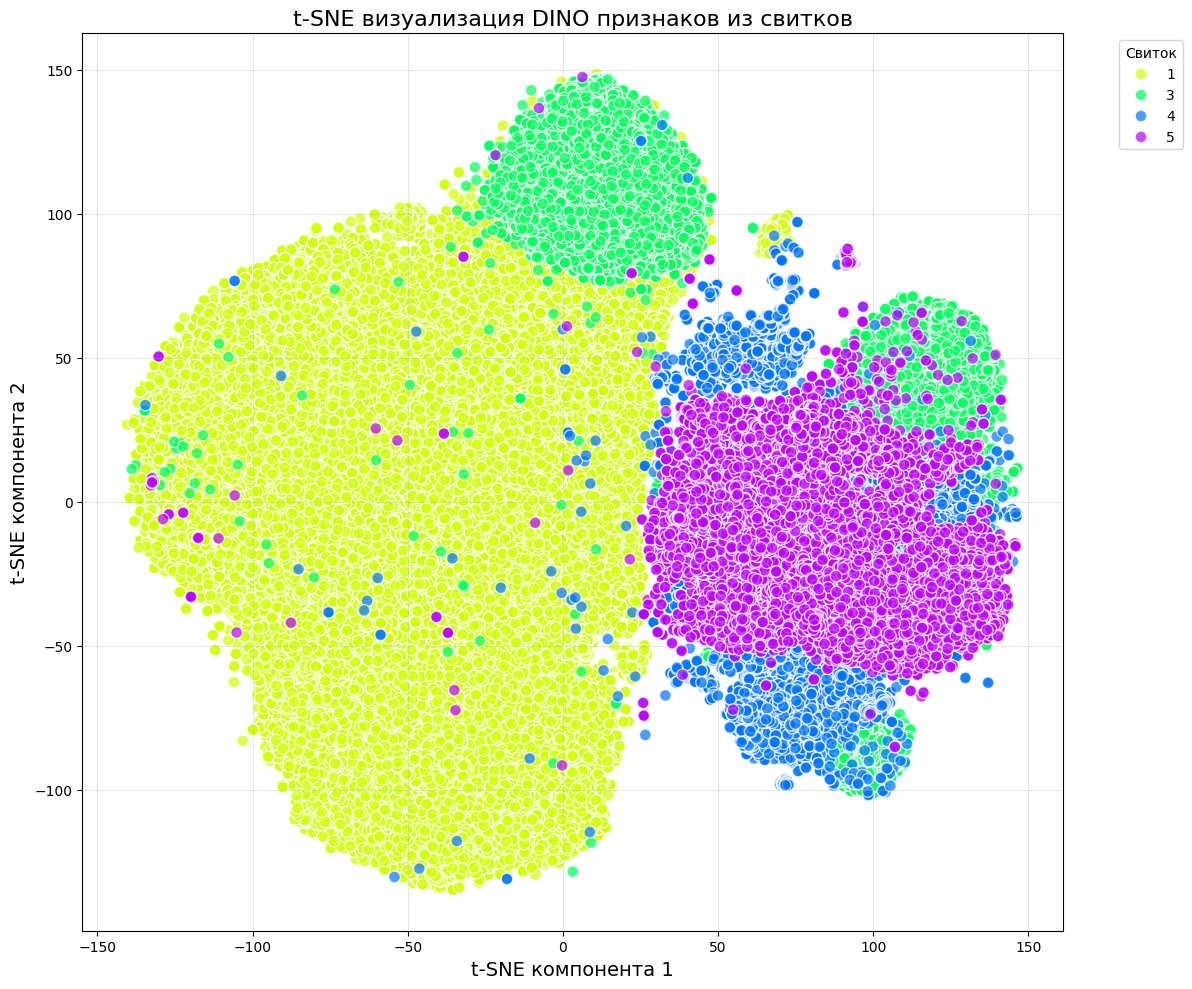

In [46]:
# Создаем DataFrame с результатами t-SNE
tsne_df = pd.DataFrame({
    'scroll': df_info.scroll.tolist(),
    #'segment': os.listdir('/home/jovyan/Bulygin/dinov2-vesuvius/output/scroll1'),
    'x': tsne_results[:, 0],
    'y': tsne_results[:, 1]
})

# Визуализация результатов
plt.figure(figsize=(12, 10))

# Создаем палитру цветов в зависимости от количества уникальных сегментов
unique_scrolls = tsne_df['scroll'].unique()
palette = sns.color_palette("hsv", len(unique_scrolls))
scroll_to_color = dict(zip(unique_scrolls, palette))

# Рисуем точки, раскрашивая их по сегменту
for scroll in unique_scrolls:
    scroll_data = tsne_df[tsne_df['scroll'] == scroll]
    plt.scatter(
        scroll_data['x'], 
        scroll_data['y'], 
        c=[scroll_to_color[scroll]] * len(scroll_data),
        label=scroll,
        alpha=0.7,
        edgecolors='w',
        s=70
    )

plt.title('t-SNE визуализация DINO признаков из свитков', fontsize=16)
plt.xlabel('t-SNE компонента 1', fontsize=14)
plt.ylabel('t-SNE компонента 2', fontsize=14)
plt.legend(title='Свиток', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(alpha=0.3)
plt.show()

# Обучаем RFC

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import pandas as pd

def train_random_forest(features):
    """
    Обучает модель случайного леса для предсказания номера свитка по признакам.
    :param features: массив признаков (numpy array)
    :param metadata: список метаданных (list of dicts)
    :return: обученная модель, отчет о классификации
    """

    metadata_df = df_info
    # Извлекаем целевую переменную  - номер свитка
    y = metadata_df['scroll'].values  # Номер свитка

    X_train, X_test, y_train, y_test = train_test_split(
        features, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print("Размер обучающей выборки:", X_train.shape)
    print("Размер тестовой выборки:", X_test.shape)
    
    # Создаем и обучаем модель случайного леса
    model = RandomForestClassifier(
        n_estimators=100, 
        random_state=42,
        n_jobs=-1  
    )
    model.fit(X_train, y_train)
    

    y_pred = model.predict(X_test)
    
    # Оцениваем качество модели
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Точность модели: {accuracy:.4f}")
    print("\nОтчет о классификации:")
    print(classification_report(y_test, y_pred))
    
    return model, classification_report(y_test, y_pred)

In [38]:
import joblib

model, report = train_random_forest(np.array(crops))

#joblib.dump(model, 'random_forest_scroll_predictor.pkl')
print("Модель сохранена в файл random_forest_scroll_predictor.pkl")

Размер обучающей выборки: (97419, 768)
Размер тестовой выборки: (24355, 768)
Точность модели: 0.9839

Отчет о классификации:
              precision    recall  f1-score   support

           1       0.99      1.00      1.00     14852
           3       0.98      0.95      0.97      3951
           4       0.94      0.88      0.91      1451
           5       0.96      0.99      0.98      4101

    accuracy                           0.98     24355
   macro avg       0.97      0.96      0.96     24355
weighted avg       0.98      0.98      0.98     24355

Модель сохранена в файл random_forest_scroll_predictor.pkl


In [31]:
import joblib

model, report = train_random_forest(features_array)

#joblib.dump(model, 'random_forest_scroll_predictor.pkl')
print("Модель сохранена в файл random_forest_scroll_predictor.pkl")

Размер обучающей выборки: (73328, 384)
Размер тестовой выборки: (18333, 384)
Точность модели: 0.7393

Отчет о классификации:
              precision    recall  f1-score   support

           1       0.80      0.85      0.82      5000
           2       0.72      0.04      0.08       637
           3       0.62      0.48      0.54      3872
           4       0.71      0.85      0.78      6629
           5       0.86      0.80      0.83      2195

    accuracy                           0.74     18333
   macro avg       0.74      0.61      0.61     18333
weighted avg       0.73      0.74      0.72     18333

Модель сохранена в файл random_forest_scroll_predictor.pkl
